# Multilayer Tidal Calculations
In this cookbook we will explore how we can use TidalPy's multilayer tidal functions to calculate tidal heating as a function of radius.

**References**:
- SVC16 : Sabadini, Vermeerson, & Cambiotti (2016), DOI: [10.1007/978-94-017-7552-6](https://doi.org/10.1007/978-94-017-7552-6).
- HH14  : Henning & Hurford (2014), DOI: [10.1088/0004-637X/789/1/30](https://doi.org/10.1088/0004-637X/789/1/30).
- TB05  : Tobie et al. (2005), DOI: [10.1016/j.icarus.2005.04.006](https://doi.org/10.1016/j.icarus.2005.04.006).
- S74   : Saito (1974), DOI: [10.4294/jpe1952.22.123](https://doi.org/10.4294/jpe1952.22.123).
- TS72  : Takeuchi & Saito (1972), DOI: [10.1016/B978-0-12-460811-5.50010-6](http://dx.doi.org/10.1016/B978-0-12-460811-5.50010-6).
- M16   : Martens (2016, [PhD Thesis](https://resolver.caltech.edu/CaltechTHESIS:04102016-211741759)), DOI: [10.7907/Z9N29TX7](http://dx.doi.org/10.7907/Z9N29TX7).
- ID    : [IcyDwarf Code](https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h) written by Marc Neveu.

## Build a Planet
For this example we will use the Io-Jupiter system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
# %matplotlib ipympl
np.seterr(divide='ignore')
from TidalPy.structures import build_world
from TidalPy.utilities.conversions import orbital_motion2semi_a
from TidalPy.utilities.numpy_helper import find_nearest
from TidalPy.rheology import Elastic, Maxwell
from TidalPy.tides.potential import tidal_potential_simple, tidal_potential_nsr
from TidalPy.RadialSolver import build_rs_input_from_data

Warning from file 'C:\Users\joepr\miniforge3\envs\tpy312\Lib\site-packages\burnman\classes\mineral.py', line 242:
You are trying to calculate shear modulus for Fe_Dewaele when it is exactly zero. 
If Fe_Dewaele is a liquid, then you can safely ignore this warning, but consider 
calculating bulk modulus or bulk sound rather than Vp or Vs. 
If Fe_Dewaele is not a liquid, then shear modulus calculations for the 
underlying equation of state (Vinet) have not been implemented, 
and Vp and Vs estimates will be incorrect.



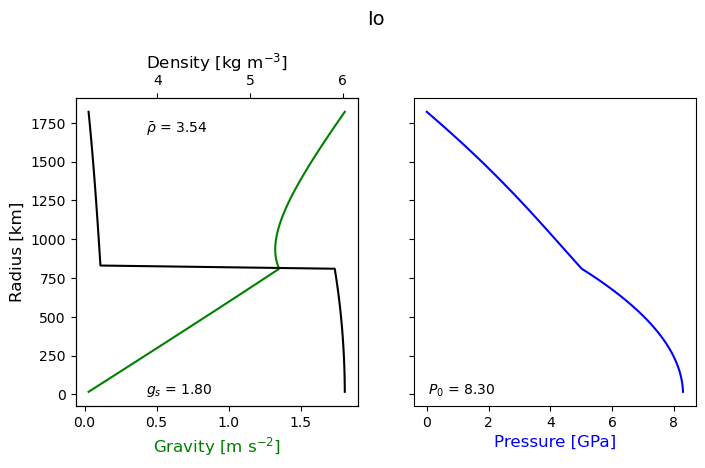

Radius array must start at zero, inserting r=0.0 at slice 0; other parameters will be set to their values at previous slice 0.
Layer 1 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.


In [2]:
io = build_world('Io')
io.paint()
jupiter = build_world('Jupiter')
tidal_host_mass = jupiter.mass
eccentricity = 0.0040313019
orbital_freq = 2. * np.pi / (86400. * 1.76914)
orbital_period = 2. * np.pi / orbital_freq
spin_rate = 1.0 * orbital_freq
periapsis = 0.0
obliquity = np.radians(0.0)
semi_major_axis = orbital_motion2semi_a(orbital_freq, tidal_host_mass, io.mass)

# Other global switches
use_simple_potential = False


# We won't be using TidalPy's OOP approach (which currently does not use the multilayer approach,
#    instead relying on a homogeneous model broken up by layers), instead we will pull out a few parameters needed
#    for the multilayer calculations.
core_radius  = io.core.radius
core_index   = io.radii <= core_radius
mantle_index = io.radii > core_radius
mantle_N     = len(io.radii[mantle_index])
core_N       = len(io.radii[core_index])
total_N      = len(io.radii)

bulk_modulus_array = 100.0e9 * np.ones(io.radii.shape, dtype=np.float64)
bulk_modulus_array[core_index] = 200.0e9

shear_modulus_array = np.zeros(io.radii.shape, dtype=np.float64)
shear_modulus_array[mantle_index] = 50.0e9

bulk_viscosity_array = 1.0e28 * np.ones_like(io.radii)

viscosity_array = 1.e1 * np.ones_like(io.radii)
viscosity_array[mantle_index] = np.logspace(23, 15, mantle_N)

rs_inputs = build_rs_input_from_data(
    orbital_freq,
    io.radii,
    io.densities,
    bulk_modulus_array,
    shear_modulus_array,
    bulk_viscosity_array,
    viscosity_array,
    (core_radius, io.radius),  # Layer upper radius
    ('liquid', 'solid'),       # Layer type
    (True, False),             # Layer is static
    (False, False),            # Layer is incompressible
    (Elastic(), Maxwell()),    # Shear rheology
    (Elastic(), Elastic()),    # Bulk rheology
    )

## Calculate the multilayer tidal response using a propagation matrix technique
TidalPy offers both a propagation matrix (HH14, SVC16, ID) and a shooting method technique (TS72, S74, TB05, M16) to calculate dissipation vs. radius.
The propagation matrix assumes incompressibility and does not allow for dynamic tides. Nor can it fully capture the propagation across liquid layers without some hacks (e.g., assume shear modulus is very small rather than zero).
The shooting method allows us the model all of the above with the addition of (since compressibility is allowed) including bulk dissipation (`Im[bulk_modulus] != 0`).
There are a few drawbacks with the current TidalPy implementation:
- Numerical stability when allowing for dynamic tides in liquid layers. Certain choices of forcing frequency can lead to numerical problems within liquid layers that can then affect other layers. If you are using liquid layers it is reccomended to turn dynamic tides off (you can leave them on in the solid layers), or if you must use dynamic tides then perform extensive testing to ensure the problem has correctly converged.
- Slow performance. Even though TidalPy utilizes JIT compiled functions, there are some aspects of the numerical shooting method that still (as of this version) utilize non-compiled python leading to slower performance. Even without these issues, the shooting method is still performing 1--3 numerical integrations per layer. If you are using this during a time integration, *especially* if considering multiple tidal modes, then calculations can slow down pretty dramatically.
    - A future version of TidalPy will offer pre-calculated lookup tables to try and mitigate this problem at the cost of a slight loss in accuracy (TODO).

In [3]:
# Load TidalPy's multilayer functions
from TidalPy.RadialSolver import radial_solver
from TidalPy.tides.multilayer.stress_strain import calculate_strain_stress

### Calculate Radial Functions

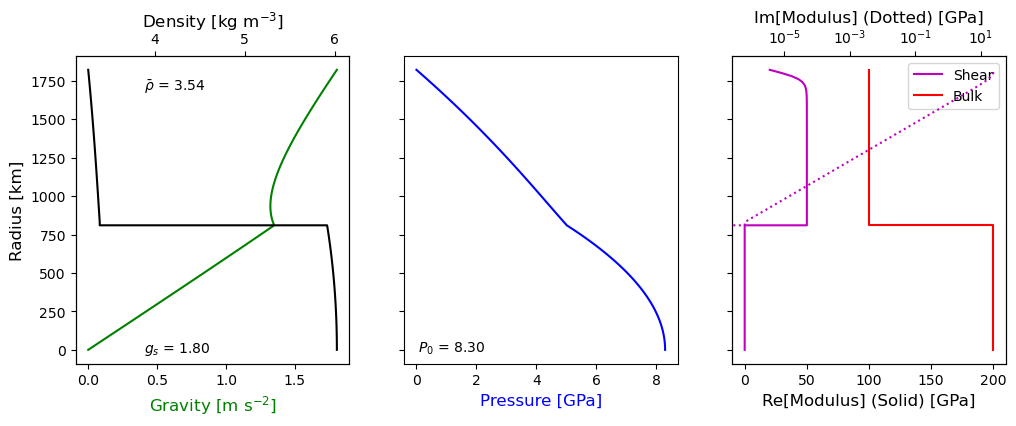

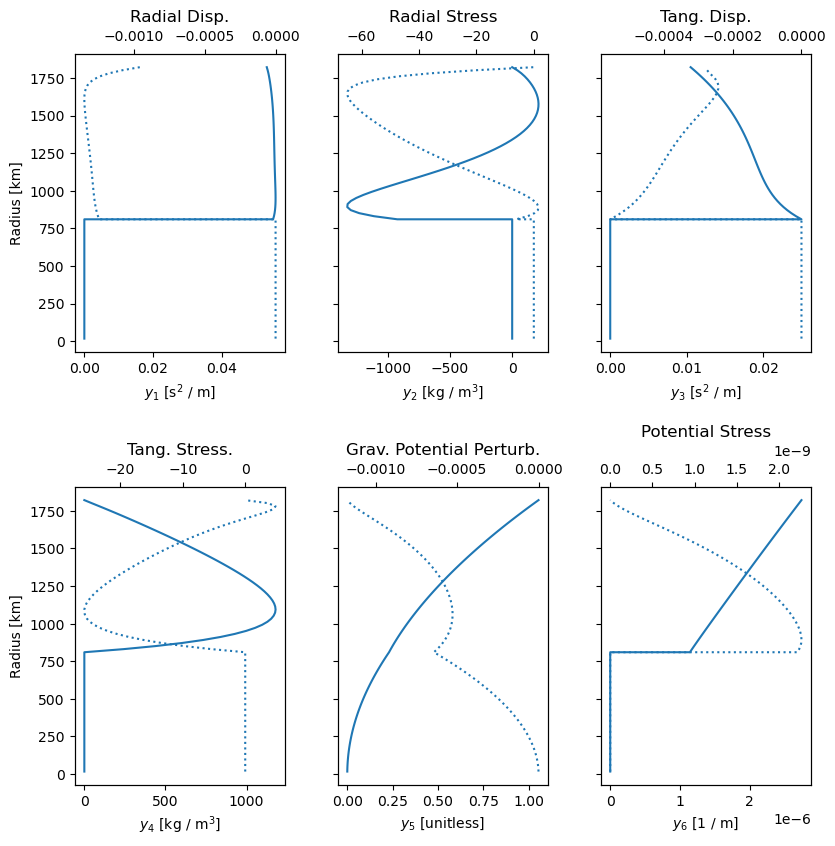

(<Figure size 950x950 with 12 Axes>,
 array([[<Axes: title={'center': 'Radial Disp.'}, xlabel='$y_{1}$ [s$^{2}$ / m]', ylabel='Radius [km]'>,
         <Axes: title={'center': 'Radial Stress'}, xlabel='$y_{2}$ [kg / m$^{3}$]'>,
         <Axes: title={'center': 'Tang. Disp.'}, xlabel='$y_{3}$ [s$^{2}$ / m]'>],
        [<Axes: title={'center': 'Tang. Stress.'}, xlabel='$y_{4}$ [kg / m$^{3}$]', ylabel='Radius [km]'>,
         <Axes: title={'center': 'Grav. Potential Perturb.'}, xlabel='$y_{5}$ [unitless]'>,
         <Axes: title={'center': 'Potential Stress'}, xlabel='$y_{6}$ [1 / m]'>]],
       dtype=object))

In [4]:
# Define default parameters to use for radial solver
radial_solver_parameters = dict(
    degree_l = 2,
    solve_for = ('tidal',),
    use_kamata = True,
    integration_method = 'DOP853',
    integration_rtol = 1.0e-6,
    integration_atol = 1.0e-10,
    scale_rtols_bylayer_type=False,
    max_num_steps = 500_000,
    expected_size = 500,
    max_ram_MB = 2000,
    max_step = 0,
    nondimensionalize = True,
    verbose = False,
    raise_on_fail = False
)

# Use numerical shooting method or matrix method
use_shooting_method = True
if use_shooting_method:
    # Use the numerical shooting method technique.
    radial_solution = \
        radial_solver(*rs_inputs, **radial_solver_parameters)
else:
    rs_parms = {**radial_solver_parameters}
    rs_parms["use_prop_matrix"] = True
    radial_solution = \
        radial_solver(*rs_inputs, **rs_parms)
# Pull out Love and Shida Numbers as well as the gravitational-viscoelastic radial solutions
k2 = radial_solution.k
h2 = radial_solution.h
l2 = radial_solution.l
tidal_y = radial_solution.result

radial_solution.plot_interior()
radial_solution.plot_ys()

## Calculate Tidal Displacement
Utilizing the simplified tidal potential (low eccentricity, no obliquity, spin-synchronous).

In [5]:
# Define latitude and longitude domain
colatitude = np.linspace(0.1, 179.9, 35)
latitude = colatitude - 90.
longitude = np.linspace(0., 360., 30)
longitude_r = np.radians(longitude)
colatitude_r = np.radians(colatitude)
time_domain = np.linspace(0., orbital_period, 100)

long_mtx, lat_mtx, time_mtx = \
    np.meshgrid(longitude_r, colatitude_r, time_domain, indexing='ij')

# Calculate the simplified tidal potential
if use_simple_potential:
    frequencies_by_name, mode_by_name, potential_by_mode = \
        tidal_potential_simple(radial_solution.radius_array, long_mtx, lat_mtx, time_mtx, orbital_freq,
                               eccentricity, tidal_host_mass, semi_major_axis)
else:
    frequencies_by_name, mode_by_name, potential_by_mode = \
        tidal_potential_nsr(radial_solution.radius_array, long_mtx, lat_mtx, time_mtx, orbital_freq, spin_rate,
                            eccentricity, tidal_host_mass, semi_major_axis)

potential, potential_dtheta, potential_dphi, potential_d2theta, potential_d2phi, potential_dtheta_dphi = \
    potential_by_mode['n']

# Scale by the tidal solutions
u_r = radial_displacement = \
    tidal_y[0, :, np.newaxis, np.newaxis, np.newaxis] * \
    potential[np.newaxis, :, :, :]
u_th = polar_displacement = \
    tidal_y[2, :, np.newaxis, np.newaxis, np.newaxis] * \
    potential_dtheta[np.newaxis, :, :, :]
u_phi = azimuthal_displacement = \
    tidal_y[2, :, np.newaxis, np.newaxis, np.newaxis] * \
    potential_dphi[np.newaxis, :, :, :] / np.sin(lat_mtx)

interactive(children=(IntSlider(value=50, description='Time Index', max=99), IntSlider(value=101, description=…

<function __main__.update_fig(time_idx=0, radius_idx=0)>

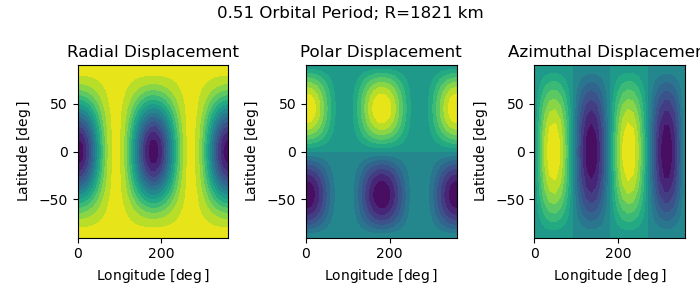

In [6]:
# Plot results
%matplotlib widget

fig_disp, axes_disp = plt.subplots(ncols=3, figsize=(7, 3))
plt.subplots_adjust(wspace=.5)
ax_disp_r = axes_disp[0]
ax_disp_th = axes_disp[1]
ax_disp_phi = axes_disp[2]

def update_fig(time_idx=0, radius_idx=0):
    orbital_period_now_displacement = time_domain[time_idx] / orbital_period
    depth_now_displacement = radial_solution.radius_array[radius_idx]
    ax_disp_r.clear()
    ax_disp_th.clear()
    ax_disp_phi.clear()
    fig_disp.suptitle(f'{orbital_period_now_displacement:0.2f} Orbital Period; R={depth_now_displacement/1000:0.0f} km')
    
    ax_disp_r.set(ylabel=r'Latitude [$\deg$]', xlabel=r'Longitude [$\deg$]',
                  title='Radial Displacement', xlim=(0, 360), ylim=(-90, 90))
    ax_disp_th.set(ylabel=r'Latitude [$\deg$]', xlabel=r'Longitude [$\deg$]',
                   title='Polar Displacement', xlim=(0, 360), ylim=(-90, 90))
    ax_disp_phi.set(ylabel=r'Latitude [$\deg$]', xlabel=r'Longitude [$\deg$]',
                    title='Azimuthal Displacement', xlim=(0, 360), ylim=(-90, 90))
    
    ax_disp_r.contourf(longitude, latitude, np.real(u_r[radius_idx, :, :, time_idx]).T, 15)
    ax_disp_th.contourf(longitude, latitude, np.real(u_th[radius_idx, :, :, time_idx]).T, 15)
    ax_disp_phi.contourf(longitude, latitude, np.real(u_phi[radius_idx, :, :, time_idx]).T, 15)
    fig_disp.tight_layout()

interact(update_fig,
         time_idx=widgets.IntSlider(min=0, max=len(time_domain)-1, step=1, value=int(len(time_domain)/2),
                                    description='Time Index'),
         radius_idx=widgets.IntSlider(min=0, max=len(radial_solution.radius_array)-1, step=int(len(radial_solution.radius_array)/20),
                                      value=len(radial_solution.radius_array)-1, description='Radius Index')
)

## Strain and Stress Tensors
Here we will calculate the strain and stress tensors using the methods described in TB05 and B13

In [7]:
strains, stresses = calculate_strain_stress(
    potential,
    potential_dtheta,
    potential_dphi,
    potential_d2theta,
    potential_d2phi,
    potential_dtheta_dphi,
    tidal_y,
    longitude_r,
    colatitude_r,
    time_domain,
    radial_solution.radius_array,
    rs_inputs.complex_shear_modulus_array,
    rs_inputs.complex_bulk_modulus_array,
    orbital_freq,
    degree_l=2)

# Strain and stress tensor is stored as a tuple of:
#    s_{rr}, s_{\theta\theta}, s_{\phi\phi}, 2 * s_{r\theta}, 2 * s_{r\phi}, 2 * s_{\theta\phi}
# The two on the cross terms is to account for the matrix being symmetric with twice the number of cross terms.
strain_rr, strain_thth, strain_phph, strain_rth, strain_rph, strain_thph = strains
stress_rr, stress_thth, stress_phph, stress_rth, stress_rph, stress_thph = stresses

### Stress and Strain over time

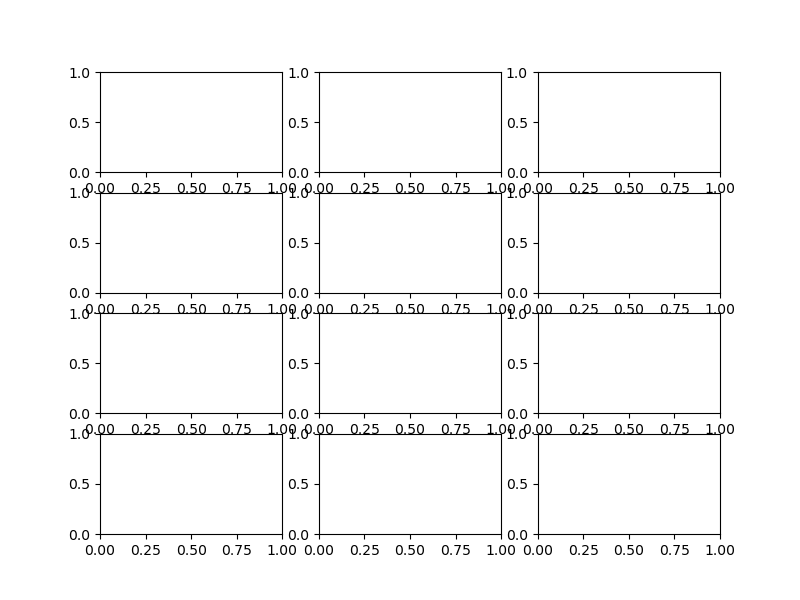

interactive(children=(IntSlider(value=50, description='Time Index', max=99), IntSlider(value=100, description=…

<function __main__.update_fig(time_idx=0, radius_idx=0, show_imaginary=False)>

In [16]:
%matplotlib widget

# Plot results
fig_strain_time, axes_stress_strain_time = plt.subplots(ncols=3, nrows=4, figsize=(8, 6))
plt.show()

def update_fig(time_idx=0, radius_idx=0, show_imaginary=False):
    
    orbital_period_now = time_domain[time_idx] / orbital_period
    depth_now = radial_solution.radius_array[radius_idx]
    
    str_pre = ''
    str_post = ''
    def scale_func(arry):
        return np.real(arry)
    if show_imaginary:
        str_pre = 'Im['
        str_post = ']'
        def scale_func(arry):
            return np.imag(arry)

    fig_strain_time.suptitle(f'{orbital_period_now:0.2f} Orbital Period; R={depth_now/1000:0.0f} km')
    tensor_txts = {0: 'rr', 1: r'\theta\theta', 2: r'\phi\phi', 3: r'\theta', 4: r'\phi', 5: r'\theta\phi'}
    ax_i = 0
    ax_j = 0

    for tensor_i, tensor_txt in tensor_txts.items():

        strain_ax = axes_stress_strain_time[ax_i, ax_j]
        stress_ax = axes_stress_strain_time[2 + ax_i, ax_j]
        strain_ax.clear()
        stress_ax.clear()
        strain_variable = strains[tensor_i][radius_idx, :, :, time_idx]
        stress_variable = stresses[tensor_i][radius_idx, :, :, time_idx]

        if tensor_i in (3, 4, 5):
            # Off diagonal tensor terms are only half counted in the tensor so need to be doubled.
            strain_variable *= 2
            stress_variable *= 2

        strain_ax.contourf(longitude, latitude, scale_func(strain_variable.T), 10)
        stress_ax.contourf(longitude, latitude, scale_func(stress_variable.T), 10)

        if ax_j == 0:
            strain_ax.set(ylabel=r'Latitude [$\deg$]')
            stress_ax.set(ylabel=r'Latitude [$\deg$]')
        if ax_i == 1:
            stress_ax.set(xlabel=r'Longitude [$\deg$]')
        strain_ax.set(title=str_pre+r'$\epsilon_{'+f'{tensor_txt}'+'}$'+str_post, xlim=(0, 360), ylim=(-90, 90))
        stress_ax.set(title=str_pre+r'$\sigma_{'+f'{tensor_txt}'+'}$'+str_post, xlim=(0, 360), ylim=(-90, 90))
        
        ax_j += 1
        if ax_j == 3:
            ax_j = 0
            ax_i += 1
    
    fig_strain_time.set_constrained_layout(True)
    plt.subplots_adjust(wspace=.2, hspace=0.55)

interact(update_fig, 
         time_idx=widgets.IntSlider(min=0, max=len(time_domain)-1, step=1, value=int(len(time_domain)/2), description='Time Index'),
         radius_idx=widgets.IntSlider(min=0, max=len(radial_solution.radius_array)-1,
                                      step=int(len(radial_solution.radius_array)/20),
                                      value=len(radial_solution.radius_array)-2, description='Radius Index'),
         show_imaginary=False)

### Stress over depth
**Latitude: 0, Longitude: 0**

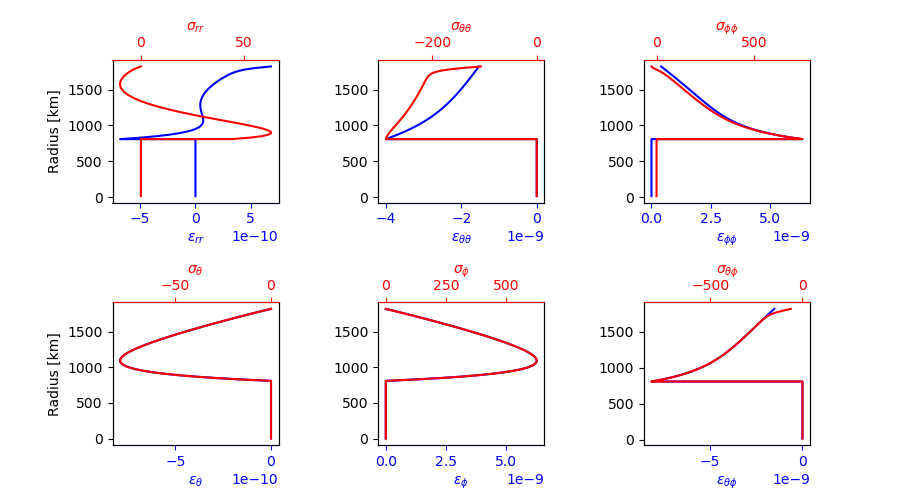

In [14]:
latitude_idx = find_nearest(latitude, 25.)
longitude_idx = find_nearest(longitude, 120.)
time_index = 5

show_real = False
show_imag = False
show_abs = False

# Plot results
fig_strain_depth, axes_strain_depth = plt.subplots(ncols=3, nrows=2, figsize=(9, 5))
plt.subplots_adjust(wspace=.6, hspace=0.7)

def scale_func(arry):
    return np.real(arry)

str_pre = ''
str_post = ''
if show_real:
    str_pre = 'Re['
    str_post = ']'
    def scale_func(arry):
        return np.real(arry)
elif show_imag:
    str_pre = 'Im['
    str_post = ']'
    def scale_func(arry):
        return np.imag(arry)
elif show_abs:
    str_pre = '|'
    str_post = '|'
    def scale_func(arry):
        return np.abs(arry)

tensor_txts = {0: 'rr', 1: r'\theta\theta', 2: r'\phi\phi', 3: r'\theta', 4: r'\phi', 5: r'\theta\phi'}
ax_i = 0
ax_j = 0

for tensor_i, tensor_txt in tensor_txts.items():

    strain_ax = axes_strain_depth[ax_i, ax_j]
    strain_ax.spines['bottom'].set_color('blue')
    strain_ax.xaxis.label.set_color('blue')
    strain_ax.tick_params(axis='x', colors='blue')

    stress_ax = strain_ax.twiny()
    stress_ax.spines['top'].set_color('red')
    stress_ax.xaxis.label.set_color('red')
    stress_ax.tick_params(axis='x', colors='red')

    strain_variable = strains[tensor_i][:, longitude_idx, latitude_idx, time_index]
    stress_variable = stresses[tensor_i][:, longitude_idx, latitude_idx, time_index]

    if tensor_i in (3, 4, 5):
        # Off diagonal tensor terms are only half counted in the tensor so need to be doubled.
        strain_variable *= 2
        stress_variable *= 2

    strain_ax.set(xlabel=str_pre+r'$\epsilon_{'+f'{tensor_txt}'+'}$'+str_post)
    stress_ax.set(xlabel=str_pre+r'$\sigma_{'+f'{tensor_txt}'+'}$'+str_post)
    if ax_j == 0:
        strain_ax.set(ylabel='Radius [km]')

    strain_ax.plot(scale_func(strain_variable), radial_solution.radius_array / 1000., 'b-')
    stress_ax.plot(scale_func(stress_variable), radial_solution.radius_array / 1000., 'r-')
    
    ax_j += 1
    if ax_j == 3:
        ax_j = 0
        ax_i += 1
    
fig_strain_depth.set_constrained_layout(True)
plt.show()

## Tidal Heating Rate


In [10]:
# Calculate tidal heating based on the stress and strain values
# Heating is equal to imag[o] * real[s] - real[o] * imag[s] but we need to multiply by two for the cross terms
#    since it is part of a symmetric matrix but only one side of the matrix is calculated in the previous steps.
# First calculate the trace terms which are not multiply by two.
volumetric_heating = (
        # Im[\sigma_ij] * Re[\epsilon_ij]
            (
                    np.sum(np.imag(stresses[:3]) * np.real(strains[:3]), axis=0) +
                    # Now add the cross terms where we do multiply by two
                    2. * np.sum(np.imag(stresses[:3]) * np.real(strains[:3]), axis=0)
            ) -
            # minus Re[\sigma_ij] * Im[\epsilon_ij]
            (
                    np.sum(np.real(stresses[3:]) * np.imag(strains[3:]), axis=0) +
                    2. * np.sum(np.real(stresses[3:]) * np.imag(strains[3:]), axis=0)
            )
    )
volumetric_heating = np.abs(volumetric_heating)

# The total heating is equal to the volumetric heating times the volume within each voxel.
# TidalPy has an easy function to find these volumes
from TidalPy.utilities.spherical_helper.volume import calculate_voxel_volumes
voxel_volume = calculate_voxel_volumes(radial_solution.radius_array, longitude_r, colatitude_r)

# Need to increase the dimensions of the voxel volume so that it can be multipled by the heating
#    which is also defined across the time domain.
voxel_volume_higher_dim = voxel_volume[:, :, :, np.newaxis]
heating = volumetric_heating * voxel_volume_higher_dim

from scipy.integrate import trapezoid
# Now lets average the heat across one orbital period
heating_orb_avg = (1. / orbital_period) * trapezoid(heating, time_domain, axis=-1)
volumetric_heating_orb_avg = (1. / orbital_period) * trapezoid(volumetric_heating, time_domain, axis=-1)

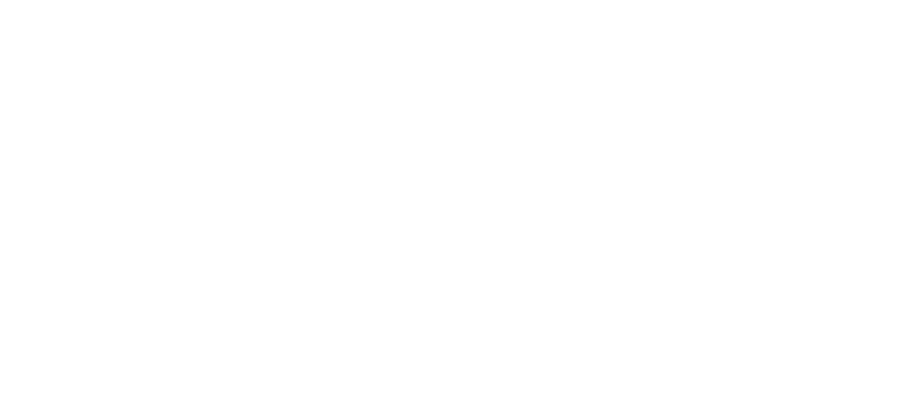

interactive(children=(IntSlider(value=50, description='Time Index', max=99), IntSlider(value=101, description=…

<function __main__.update_fig(time_idx=0, radius_idx=-1, sum_depth=False, show_flux=True, fixed_long=0.0, fixed_lat=0.0, orbit_average=False)>

In [11]:
# Setup Figure
from matplotlib.gridspec import GridSpec
fig_heat = plt.figure(figsize=(9, 4))
gs = GridSpec(
    1, 4, width_ratios=[0.4, 0.05, 0.1, 0.4], figure=fig_heat, wspace=0.2
)
plt.show()
axis_heat = fig_heat.add_subplot(gs[0, 0])
cbar_ax = fig_heat.add_subplot(gs[0, 1])
axis_heat_depth = fig_heat.add_subplot(gs[0, 3])

# Initial plot
cb_data = axis_heat.contourf(longitude, latitude, np.zeros((longitude.size, latitude.size)).T, 15)
cb_heat = fig_heat.colorbar(cb_data, cax=cbar_ax)

def update_fig(time_idx=0, radius_idx=-1,
               sum_depth = False, show_flux = True,
               fixed_long=0., fixed_lat=0., orbit_average=False):

    global cb_data, cb_heat

    # Clear main plot + depth plot
    axis_heat.clear()
    axis_heat_depth.clear()

    # Remove old contour and colorbar
    # cb_data.remove()
    # cb_heat.remove()

    # Determine if we are averaging over the orbit
    if orbit_average:
        heating_to_plot = heating_orb_avg
        heating_at_depth = volumetric_heating_orb_avg
    else:
        heating_to_plot = heating[:, :, :, time_idx]
        heating_at_depth = volumetric_heating[:, :, :, time_idx]

    # Determine if we are summing over the depth of the world
    if sum_depth:
        heating_to_plot = np.nansum(heating_to_plot, axis=0)
    else:
        heating_to_plot = heating_to_plot[radius_idx]

    # Plot Results
    axis_heat.clear()
    axis_heat_depth.clear()
    plt.subplots_adjust(wspace=.1, hspace=0.3)

    # Set figure title
    orbital_period_now = time_domain[time_idx] / orbital_period
    depth_now = radial_solution.radius_array[radius_idx]
    fig_heat.suptitle(f'{orbital_period_now:0.2f} Orbital Period; {depth_now/1000:0.0f} km')

    axis_heat.set(title='Tidal Heating [W]')
    if show_flux:
        if sum_depth:
            heating_to_plot = heating_to_plot / world_surf_area
        else:
            heating_to_plot = heating_to_plot / (4. * np.pi * radial_solution.radius_array[radius_idx]**2)
        axis_heat.set(title='Surface Heating Flux [W m-2]')
    axis_heat.set(ylabel=r'Latitude [$\deg$]', xlabel=r'Longitude [$\deg$]', xlim=(0, 360), ylim=(-90, 90))

    cb_data = axis_heat.contourf(longitude, latitude, heating_to_plot.T, 15)
    cb_heat = fig_heat.colorbar(cb_data, cax=cbar_ax)
    
    # plot depth at sub-stellar point
    lat_indx = find_nearest(latitude, fixed_lat)
    long_indx = find_nearest(longitude, fixed_long)
    axis_heat_depth.plot(heating_at_depth[:, long_indx, lat_indx], radial_solution.radius_array/1000.)
    axis_heat_depth.set(xlabel='Tidal Heating [W m-3]', ylabel='Radius [km]', xscale='log')

    axis_heat.plot([longitude[long_indx]], [latitude[lat_indx]], marker='x', c='r')

    fig_heat.set_constrained_layout(True)

interact(update_fig,
         time_idx=widgets.IntSlider(min=0, max=len(time_domain)-1, step=1, value=int(len(time_domain)/2), description='Time Index'),
         radius_idx=widgets.IntSlider(min=0, max=len(radial_solution.radius_array)-1, step=1,
                                      value=len(radial_solution.radius_array)-1, description='Radius Index'),
         sum_depth=widgets.Checkbox(value=False, description='Sum Depths'),
         show_flux=widgets.Checkbox(value=True, description='Heat Flux'),
         orbit_average=widgets.Checkbox(value=False, description='Orbit Averaged'),
         fixed_long=widgets.IntSlider(min=0, max=360, step=30, value=180, description=r'Fixed $\phi$'),
         fixed_lat=widgets.IntSlider(min=-90, max=90, step=30, value=0, description=r'Fixed $\theta$')
)

## Compare Matrix Propagation vs. Shooting Method

### Radial Function Results

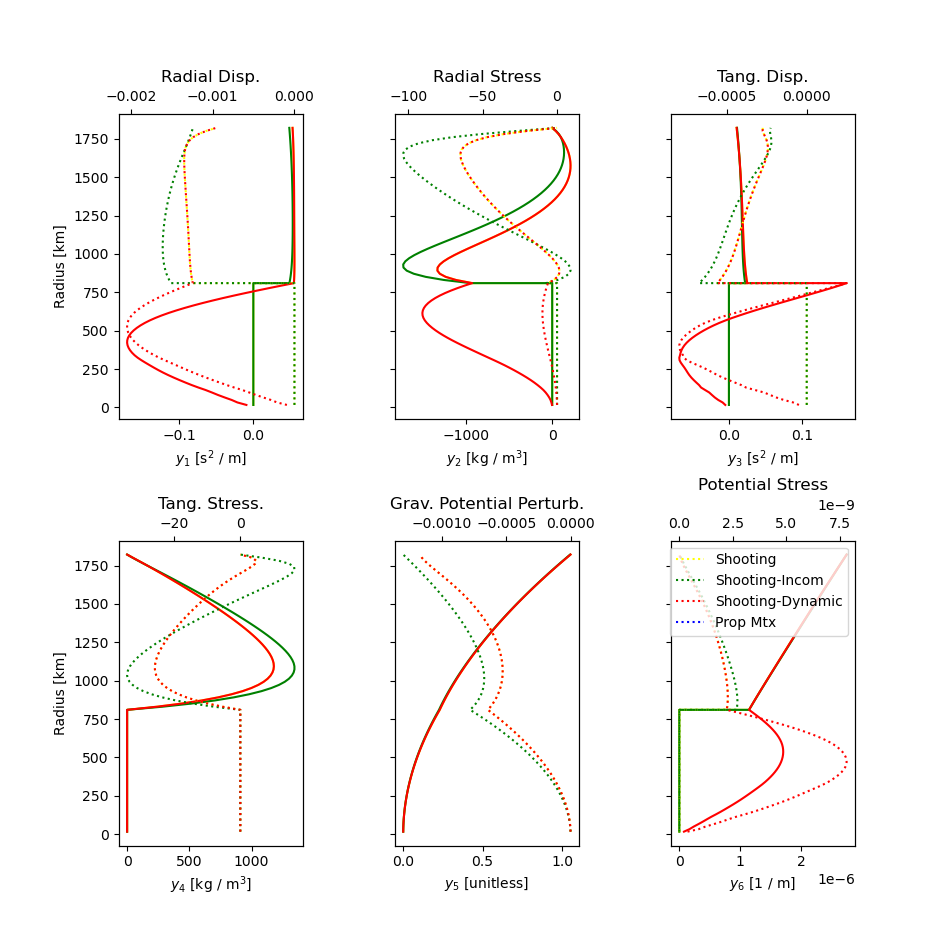

In [12]:
def shooting_radial(core_static=True, mantle_static=False, incompressible=False):
    rs_input_copy = list(rs_inputs)
    rs_input_copy[7] = (core_static, mantle_static)
    rs_input_copy[8] = (incompressible, incompressible)
    rs_input_copy = tuple(rs_input_copy)
    
    radial_solution = \
        radial_solver(*rs_input_copy, **radial_solver_parameters)
    
    # Pull out Love and Shida Numbers as well as the gravitational-viscoelastic radial solutions
    k2 = radial_solution.k
    h2 = radial_solution.h
    l2 = radial_solution.l
    tidal_y = np.copy(radial_solution.result)
    
    return tidal_y, (k2, h2, l2)

def prop_matrix_radial():
    rs_input_copy = list(rs_inputs)
    rs_input_copy[6] = ('solid',) # Layer type
    rs_input_copy[7] = (True,)  # Layer is static
    rs_input_copy[8] = (True,)  # Layer is incompressible
    rs_input_copy[9] = np.asarray((rs_inputs[9][1],))
    
    rs_input_copy = tuple(rs_input_copy)
    rs_parms = {**radial_solver_parameters}
    rs_parms["use_prop_matrix"] = True
    rs_parms["starting_radius"] = core_radius
    
    radial_solution = \
        radial_solver(*rs_input_copy, **rs_parms)
    
    # Pull out Love and Shida Numbers as well as the gravitational-viscoelastic radial solutions
    k2 = radial_solution.k
    h2 = radial_solution.h
    l2 = radial_solution.l
    tidal_y = np.copy(radial_solution.result)
    return tidal_y, (k2, h2, l2)
    
shooting_tidal_y, shooting_loves = \
    shooting_radial(core_static=True, mantle_static=False, incompressible=False)
shooting_tidal_y_incom, shooting_loves_incom = \
    shooting_radial(core_static=True, mantle_static=False, incompressible=True)
shooting_tidal_y_dynamic, shooting_loves_dynamic = \
    shooting_radial(core_static=False, mantle_static=False, incompressible=False)
# shooting_tidal_y_dynamic_incom, shooting_loves_dynamic_incom = \
#     shooting_radial(incompressible=True, core_static=False, non_dimensionalize=True)
propmtx_tidal_y, propmtx_loves = \
    prop_matrix_radial()

radii = radial_solution.radius_array
ys = [shooting_tidal_y, shooting_tidal_y_incom, shooting_tidal_y_dynamic, propmtx_tidal_y]
rs = [radii, radii, radii, radii]
labels = ['Shooting', 'Shooting-Incom', 'Shooting-Dynamic', 'Prop Mtx']
colors = ['yellow', 'green', 'red', 'blue']

from TidalPy.utilities.graphics.multilayer import yplot
fig = yplot(ys, rs, labels=labels, colors=colors, show_plot=False)
plt.legend()
plt.subplots_adjust(wspace=.5, hspace=0.4)
plt.show()

### Radial Function Performance
Here we will compare the perfomance of prop matrix vs. shooting method. Note this is not a purely apples to apples comparison since we are using wrapping functions and the prop matrix technique is not calculating over the full radial domain. But it will give an order of magnitude estimate

In [13]:
run_performance = True

if run_performance:
    print('Shooting (Static Core)')
    %timeit shooting_radial(core_static=True, mantle_static=False, incompressible=False)
    print('\nShooting (Static Core; Incompressible)')
    %timeit shooting_radial(core_static=True, mantle_static=False, incompressible=True)
    print('\nShooting (Dynamic Core)')
    %timeit shooting_radial(core_static=False, mantle_static=False, incompressible=False)
    print('\nPropagation Matrix')
    %timeit prop_matrix_radial()

Shooting (Static Core)
1.89 ms ± 277 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Shooting (Static Core; Incompressible)
1.71 ms ± 80.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Shooting (Dynamic Core)
3.56 ms ± 57.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Propagation Matrix
130 μs ± 3.01 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
